In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from diffractio.scalar_masks_X import Scalar_mask_X
%matplotlib ipympl


Recreating the Cardinal Lens, https://opg.optica.org/ao/fulltext.cfm?uri=ao-63-4-1110&id=546054#articleSupplMat 

and diffraction grating example from zemax in the supplementary:

https://opticapublishing.figshare.com/articles/journal_contribution/Supplementary_document_for_Ray-Tracing_Model_of_a_Perfect_Lens_Compliant_with_Fermat_s_Principle_The_Cardinal_Lens_-_6813155_pdf/24969966

Note that I am ignoring the refractive indices n1 and n2 in the paper, because in electron optics once the electron leaves the lens/component,
we are making the approximation that the refractive index the electron sees is 1 (free space) everywhere, because there should be no potential in those regions. However it is easy to add it in if so desired. 

In [33]:
# Function to calculate the pixel coordinate that a ray hits the detector. (Used for summing ray phase for diffraction grating simulation).
def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = np.eye(2)

    y_transformed, x_transformed = (np.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

# If we want to check that the optical path lengths that the diffraction grating and 
# lens work correctly, we can use this function to plot the "wavefront" along the rays. 
# The diffraction grating should make a new plane wave, where the new deflected wavefront is still 
# everywhere perpendicular to the rays. The lens should in general make circular wavefronts
# converging to a point in the image or focal plane. 
def interp_coordinates_from_optical_path_length(opl_0, opl_1, z_0, z_1, x_0, x_1, opl_value):
    N = len(opl_0)
    opl = np.vstack([opl_0, opl_1]).T
    z = np.vstack([z_0, z_1]).T
    x = np.vstack([x_0, x_1]).T

    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    fn_vectorized = np.vectorize(interp1d,
                                        signature='(n),(n)->()')
    # Generate array of interpolation functions for z from opl
    interp_fn_array_z_from_opl = fn_vectorized(opl, z)

    # Generate array of interpolation functions for x from z
    interp_fn_array_x_from_z = fn_vectorized(z, x)

    # Initialize arrays for results
    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    # Evaluate the interpolated values
    for i in range(N):
        z_given_opl[i] = interp_fn_array_z_from_opl[i](opl_value)
        x_given_z[i] = interp_fn_array_x_from_z[i](z_given_opl[i])
        
    return z_given_opl, x_given_z

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N

# Function to propagate a distance z, and obtain the new optical path length. 
def propagate(x, y, z, L, M, N, d, opl):
    dx = (L / N) * d
    dy = (M / N) * d
    dz = (N / N) * d
    x1 = x + dx
    y1 = y + dy
    z1 = z + dz
    
    opl_out = opl + np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return x1, y1, z1, opl_out

# Essentially following zemax forum post here: https://support.zemax.com/hc/en-us/articles/1500005489061-How-diffractive-surfaces-are-modeled-in-OpticStudio
# Except we are randomly deciding on the diffraction order, since we are using a monte carlo method to simulate one ray at a time,
# and we can't easily split rays
def diffraction_grating(x, y, z, L, M, opl, wl, F = 200, diffraction_order_choices = [-1, 1]):
    diffraction_order = np.random.choice(diffraction_order_choices, len(x))

    L1 = L
    M1 = M + (diffraction_order * wl * F)
    N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2)
    opl1 = opl + (diffraction_order * wl * F * y)
    
    return x, y, z, L1, M1, N1, opl1

def rotation_matrix(x, y, alpha):
    return x * np.cos(alpha) - y * np.sin(alpha), x * np.sin(alpha) + y * np.cos(alpha)

Main functions of this notebook

In [34]:
# Essentially the code as sent from Jeffrey, with my own additions of the optical path length
def perfect_lens(u1, v1, L1, M1, N1, f, m_p, opl_in):
    
    '''
    The following parameters are taken as inputs:

    (u1, v1):  incoming ray intercept coordinates (1st principal plane)
    (l1, m1, n1):  incoming ray direction cosines

    f:  lens focal length
    m_p: transverse paraxial magnfication
    
    opl_in: Optical path length of input ray at 1st principal plane of lens
    '''
    # Initial Numerical Aperture
    NA1 = 0.1
    NA2 = 0.1
    
    # Check if magnification is too small or large, and thus a finite-long conjugate approximation
    # is applied
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
    
    # If so, we need to set the signal that the numerical aperture is 
    # 0.0, neccessary for later
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
    
    m_p = z2 / z1
    
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        L1_est = - (x1 - u1) / r1_mag
        M1_est = - (y1 - v1) / r1_mag
        print('M1_est=', M1_est)
    else:
        
        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
    
    # Principal Ray directions
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        N1_p = N1
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        N1_p = np.sqrt(1 - L1_p ** 2 - M1_p ** 2)
    
    # Coordinates in image plane or focal plane
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p / N1_p)
        y2 = z2 * (M1_p / N1_p)
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
    else:
        a = x1 / z1
        b = y1 / z1
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
    
    # Calculation to back propagate to right hand side principal plane
    Cx = m_p * L2_p - L1_p
    Cy = m_p * M2_p - M1_p  
    
    if (NA1 == 0.0):
        L2 = (L1_est + Cx) / m_p
        M2 = (M1_est + Cy) / m_p
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / m_p
        M2 = (M1 + Cy) / m_p
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    # We use a mask to find rays that have gone to the centre,
    # because we are not inputting one ray at a time, but a vector of rays. 
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7
    
    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # For the case where the mask is false, (rays are not going through the centre of the lens)
    not_mask = ~mask
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]

    # Calculate final distance from image/focal plane to point ray leaves lens for optical path length
    # calculation
    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    
    opl1 = r1_mag + r2_mag # Ray opl
    opl0 = p1_mag + p2_mag # Principal ray opl
    
    opl = opl_in + (opl0 - opl1)

    return u2, v2, L2, M2, N2, opl


In [35]:
def fourier_lens(u1, v1, L1, M1, N1, f, m_p, opl_in):
    
    '''
    The following parameters are taken as inputs:

    (u1, v1):  incoming ray intercept coordinates (1st principal plane)
    (l1, m1, n1):  incoming ray direction cosines

    f:  lens focal length
    m_p: transverse paraxial magnfication
    
    opl_in: Optical path length of input ray at 1st principal plane of lens
    '''
    
    # # Determine angle of ray with respect to y axis
    # alpha = np.arctan2(v1, u1) + np.pi / 2
    
    # # And rotate coordinate vectors so they are in the y - axis 
    # # This is neccessary for the fourier lens to meet the abbe sine condition
    # u1, v1 = rotation_matrix(u1, v1, alpha)
    # L1, M1 = rotation_matrix(L1, M1, alpha)
    
    # Initialise numerical aperture
    NA1 = 0.1
    NA2 = 0.1
    
    # Check if magnification is too small or large, and thus a finite-long conjugate approximation
    # is applied
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
        
    m_p = z2 / z1
    
    ''' Comment from Jeffrey Wilde: Check again for infinite conjugates, but this time use z1, z2.  It's possible that some values
    of M exist for the "finite conjugate" case above that may lead to z1 or z2 outside of the +/-1e10 limits, 
    so we should treat such instances as infinite conjugate and therefore force z1,z2 to remain bounded 
    at our desired  +/-1e10 limits. '''
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
        
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        
        # We also numerically calculate dx and dy for abbe sine condition later
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
        
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        L1_est = - (x1 - u1) / r1_mag
        M1_est = - (y1 - v1) / r1_mag
        print('M1_est=', M1_est)
    else:
        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        #Numerical solution to dx and dy of lens
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
    
    # Obtain direction cosines of incoming principal ray
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        
        dL1_p = L1
        dM1_p = M1
        
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
        
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        
        dL1_p = (dx1 / dp1_mag) * z1 / np.abs(z1)
        dM1_p = (dy1 / dp1_mag) * z1 / np.abs(z1)
    
    # Obtain positions of ray in image plane, and direction cosines of outgoing principal ray
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p)
        y2 = z2 * (M1_p)
        
        #Numerical solution to dx and dy of lens
        dx2 = z2 * dL1_p 
        dy2 = z2 * dM1_p
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    else:
        L2_p = (x1 / z1) * (z2 / np.abs(z2))
        M2_p = (y1 / z1) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        #Numerical solution to dx and dy of len
        dL2_p = (dx1 / z1) * (z2 / np.abs(z2))
        dM2_p = (dy1 / z1) * (z2 / np.abs(z2))
        dN2_p = np.sqrt(1 - dL2_p ** 2 - dM2_p ** 2)
        
        dx2 = (dL2_p / dN2_p) * z2
        dy2 = (dM2_p / dN2_p) * z2
        
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
    
    # Calculate ray positions in second principal plane of lens using numerical approximation
    # of the abbe sine condition
    mdx = dx2 / dx1
    mdy = dy2 / dy1
    
    mask_mdx = np.abs(mdx) < 1e-15
    mask_mdy = np.abs(mdy) < 1e-15
    
    mdx[mask_mdx] = m_p
    mdy[mask_mdy] = m_p
    
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p  
    
    if (NA1 == 0.0):
        L2 = L1_est * 0.0
        M2 = (M1_est + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / mdx
        M2 = (M1 + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    # Calculate the mask for the condition
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7

    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0 (rays go through centre of lens)
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # Apply the rotation_matrix function
    # L2[mask], M2[mask] = rotation_matrix(L2[mask], M2[mask], -alpha[mask])
    # u2[mask], v2[mask] = rotation_matrix(u2[mask], v2[mask], -alpha[mask])

    # For the case where the mask is false (rays don't go through centre of lens)
    not_mask = ~mask
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    
    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]

    # Calculate final distance from image/focal plane to point ray leaves lens for optical path length
    # calculation
    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    
    opl1 = r1_mag + r2_mag # Ray opl
    opl0 = p1_mag + p2_mag # Principal ray opl
    
    opl = opl_in + (opl0 - opl1)

    # Apply the rotation_matrix function again to get unrotated ray positions and direction cosines in
    # second principal plane of lens
    # L2[not_mask], M2[not_mask] = rotation_matrix(L2[not_mask], M2[not_mask], -alpha[not_mask])
    # u2[not_mask], v2[not_mask] = rotation_matrix(u2[not_mask], v2[not_mask], -alpha[not_mask])

    return u2, v2, L2, M2, N2, opl

Simple test example of fourier lens and perfect lens. Setting coordinates

In [36]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -1e-11
f = 10

# Choose z positions to plot based on magnification
if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
elif np.abs(m_p) > 1e10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of ray starting positions
x1 = np.linspace(0.0, 0.0, N)
y1 = np.linspace(5, 1, N)
z1 = np.linspace(z1, z1, N)

angles = np.linspace(0, 0, N)

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction cosine

Perform calculation for perfect lens. 

In [37]:
# Obtain the location where the ray hits the first principal plane
u1 = - (L1 / N1) * z1 + x1
v1 = - (M1 / N1) * z1 + y1

# Calculate OPL at lens
opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)

u2, v2, L2, M2, N2, opl = perfect_lens(u1, v1, L1, M1, N1, f, m_p, opl_in)

# Calculate ray position in image plane
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2

# And new OPL
opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

M1_est= [5.00000000e-10 4.55555556e-10 4.11111111e-10 3.66666667e-10
 3.22222222e-10 2.77777778e-10 2.33333333e-10 1.88888889e-10
 1.44444444e-10 1.00000000e-10]


Plot perfect lens rays. 

(-11.0, 11.0, -1.338675134594813, 6.112177826491071)

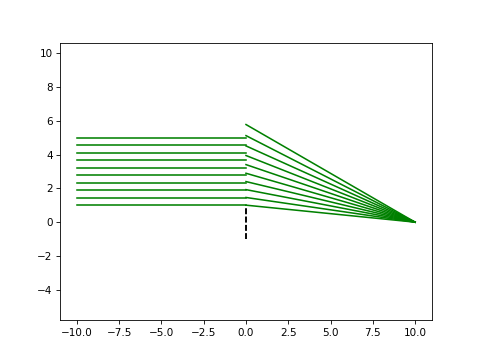

In [38]:
# Create plot
plt.figure()

plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-g')
plt.plot([], [], '-g', label = 'Perfect Lens Jeff')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-g')
plt.axis('equal')


Calculate Fourier lens rays.

In [39]:
opl_in = np.zeros(N)

# Obtain the location where the ray hits the first principal plane
u1 = - (L1 / N1) * z1 + x1
v1 = - (M1 / N1) * z1 + y1

opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)
opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)

u2, v2, L2, M2, N2, opl = fourier_lens(u1, v1, L1, M1, N1, f, m_p, opl_in)
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2


M1_est= [5.00000000e-10 4.55555556e-10 4.11111111e-10 3.66666667e-10
 3.22222222e-10 2.77777778e-10 2.33333333e-10 1.88888889e-10
 1.44444444e-10 1.00000000e-10]


Plot Fourier lens rays on plot above.  (Zoom in to notice fourier lens is distorted as expected in the imaging plane).

In [40]:
plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-b')
plt.plot([], [], '-b', label = 'Fourier Lens Jeff')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-b')
plt.axis('equal')
plt.legend()

Now we recreate diffraction grating result with a very crude ray tracer. 

In [41]:
# Set up coordinates and settings of lenses
plane_wave_z = 0.0
diff_grating_z = 10
lens_z_1 = 20
lens_z_2 = 32

wl = 0.0005

f1 = 10
f2 = 2
m_p1 = -1e-11
m_p2 = 1e11
zl_1_1 = -f1
zl_1_2 = f1

zl_2_1 = -f2
zl_2_2 = f2


This first diffraction grating example is just to plot a sanity check, that the optical path length is calculated correctly - i.e the diffraction grating deflects plane waves, and the lens makes circular wavefronts converging on a point. 

In [42]:
N = 10

# Setup initial coordinates of incoming plane wave
ry = np.linspace(-2, 2, N)

rx, rz = np.linspace(0, 0, N),  np.linspace(plane_wave_z, plane_wave_z, N)
M0, L0, N0 = np.linspace(0, 0, N), np.linspace(0, 0, N), np.linspace(1, 1, N)

opl0 = np.linspace(0, 0, N)

# Diffraction Grating Frequency: 
F = 100

# Propagate from to left side of diffraction grating
rx_diff_l, ry_diff_l, rz_diff_l, opl1 = propagate(rx, ry, rz, L0, M0, N0, diff_grating_z - plane_wave_z, opl0)

# Calculate diffraction grating phase and angle shift
rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, opl2 = diffraction_grating(rx_diff_l, ry_diff_l, rz_diff_l, L0, M0, opl1, wl, 
                                                                        F = F, diffraction_order_choices = [1])
# Propagate to left side of first lens
rx_lens1_l, ry_lens1_l, rz_lens1_l, opl3 = propagate(rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, lens_z_1 - diff_grating_z, opl2)

# Calculate lens phase and angle shift
rx_lens1_r, ry_lens1_r, L2, M2, N2, opl4 = fourier_lens(rx_lens1_l, ry_lens1_l, L1, M1, N1, f1, m_p1, opl3)

# Propagate to second lens
rx_lens2_l, ry_lens2_l, rz_lens2_l, opl5 = propagate(rx_lens1_r, ry_lens1_r, lens_z_1, L2, M2, N2, 12, opl4)

# Calculate lens phase and angle shift
rx_lens2_r, ry_lens2_r, L3, M3, N3, opl6 = fourier_lens(rx_lens2_l, ry_lens2_l, L2, M2, N2, f2, m_p2, opl5)

# Propagate to end
rx_end, ry_end, rz_end, opl7 = propagate(rx_lens2_r, ry_lens2_r, lens_z_2, L3, M3, N3, f2, opl6)

# Calculate wavefront points along ray given an optical path length
opl_value = 11
z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(opl2, opl3, 
                                                                        rz_diff_r, rz_lens1_l,
                                                                        ry_diff_r, ry_lens1_l,
                                                                        opl_value)

opl_value = 22
z02_given_opl, x02_given_z = interp_coordinates_from_optical_path_length(opl4, opl5, 
                                                                        rz_lens1_l, rz_lens2_l,
                                                                        ry_lens1_r, ry_lens2_l,
                                                                        opl_value)
opl_value = 33
z03_given_opl, x03_given_z = interp_coordinates_from_optical_path_length(opl6, opl7, 
                                                                        lens_z_2, lens_z_2 + f2,
                                                                        ry_lens2_r, ry_end,
                                                                        opl_value)


M1_est= [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


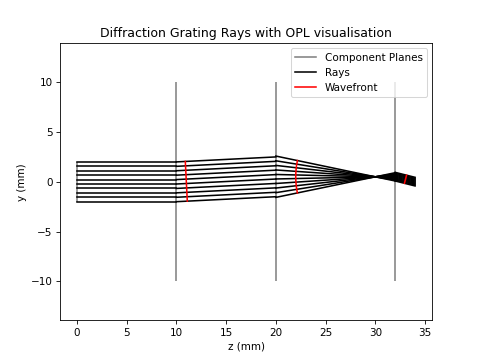

In [43]:
plt.figure()
plt.vlines(plane_wave_z, -2, 2, color = 'gray', linestyle = '-')
plt.vlines(diff_grating_z, -10, 10, color = 'gray', linestyle = '-')
plt.vlines(lens_z_1, -10, 10, color = 'gray', linestyle = '-')
plt.vlines(lens_z_2, -10, 10, color = 'gray', linestyle = '-')
plt.plot([], [], color = 'gray', linestyle = '-', label = 'Component Planes')

plt.plot([rz, rz_diff_l], [ry, ry_diff_l], '-k')
plt.plot([lens_z_1 + zl_1_1, lens_z_1], [ry_diff_r, ry_lens1_l], '-k')
plt.plot([lens_z_1, lens_z_1 + (lens_z_2 - lens_z_1)], [ry_lens1_r, ry_lens2_l], '-k')
plt.plot([lens_z_2, lens_z_2  + zl_2_2], [ry_lens2_r, ry_end], '-k')
plt.plot([], [], '-k', label = 'Rays')

plt.plot(z01_given_opl, x01_given_z, '-r')
plt.plot(z02_given_opl, x02_given_z, '-r')
plt.plot(z03_given_opl, x03_given_z, '-r')
plt.plot([], [], '-r', label = 'Wavefront')

plt.title('Diffraction Grating Rays with OPL visualisation')
plt.ylabel('y (mm)')
plt.xlabel('z (mm)')
plt.axis('equal')
plt.legend()

It appears that the OPL is calculated correctly, so now we can perform monte carlo integraton of each ray at a pixel in the detector plane, 
to view the sinusoidal pattern of a diffraction grating. 

In [44]:
N = int(1e8)

# Sample random rays from plane wave
ry = np.random.uniform(-1, 1, N)

rx, rz = np.linspace(0, 0, N),  np.linspace(plane_wave_z, plane_wave_z, N)
M0, L0, N0 = np.linspace(0, 0, N), np.linspace(0, 0, N), np.linspace(1, 1, N)

opl0 = np.linspace(0, 0, N)

# Diffraction Grating Frequency: 
F = 100

# Propagate from to left side of diffraction grating
rx_diff_l, ry_diff_l, rz_diff_l, opl1 = propagate(rx, ry, rz, L0, M0, N0, diff_grating_z - plane_wave_z, opl0)

# Calculate diffraction grating phase and angle shift
rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, opl2 = diffraction_grating(rx_diff_l, ry_diff_l, rz_diff_l, L0, M0, opl1, wl, 
                                                                        F = F, diffraction_order_choices = [-1, 1])
# Propagate to left side of first lens
rx_lens1_l, ry_lens1_l, rz_lens1_l, opl3 = propagate(rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, lens_z_1 - diff_grating_z, opl2)

# Calculate lens phase and angle shift
rx_lens1_r, ry_lens1_r, L2, M2, N2, opl4 = fourier_lens(rx_lens1_l, ry_lens1_l, L1, M1, N1, f1, m_p1, opl3)

# Propagate to second lens
rx_lens2_l, ry_lens2_l, rz_lens2_l, opl5 = propagate(rx_lens1_r, ry_lens1_r, lens_z_1, L2, M2, N2, 12, opl4)

# Calculate lens phase and angle shift
rx_lens2_r, ry_lens2_r, L3, M3, N3, opl6 = fourier_lens(rx_lens2_l, ry_lens2_l, L2, M2, N2, f2, m_p2, opl5)

# Propagate to end
rx_end, ry_end, rz_end, opl7 = propagate(rx_lens2_r, ry_lens2_r, lens_z_2, L3, M3, N3, f2, opl6)


M1_est= [-0.05  0.05  0.05 ... -0.05 -0.05 -0.05]


Now we add up the phase of all rays in the correct detector bin, and interfere them to make an image of the diffraction grating. 

Text(0.5, 1.0, 'Amplitude Grating')

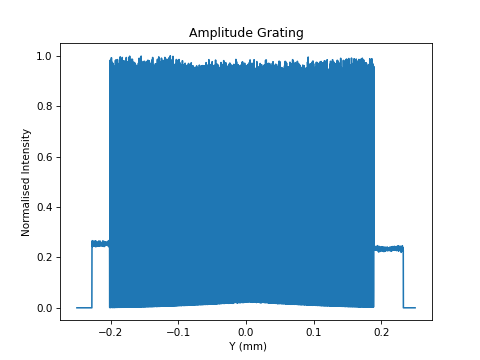

In [45]:
num_px_det_y = 5000
num_px_det_x = 1
det_image = np.zeros((num_px_det_y, num_px_det_x), dtype = np.complex128)

det_shape = [num_px_det_y, num_px_det_x]
det_width_y = 0.5
det_centre_y = 0.0

det_pixels_y, px_size_y = np.linspace(det_centre_y - det_width_y / 2, det_centre_y + det_width_y / 2, num_px_det_y, retstep = True)

# Get pixels coords and make them an integer
pixel_coords_x, pixel_coords_y = get_pixel_coords(np.zeros(ry_end.shape), ry_end, det_shape, px_size_y)
pixel_coords_y, pixel_coords_x = np.round((pixel_coords_y, pixel_coords_x)).astype(int)

sy, sx = det_shape

# This little phase shift moves the ray to the centre of the pixel, as it's very important 
# to add the rays coherently: See page 26 of Marco Mouts thesis:
 #https://pure.tudelft.nl/ws/files/54806574/BM_Mout_dissertation_Ray_based_diffraction_methods.pdf
dx = np.sqrt((ry_end - det_pixels_y[pixel_coords_y]) ** 2)
ray_phase = np.exp(1j * (2*np.pi / wl) * (opl7 + dx * M3))

# Get mask to select ray indices on detector
mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)


# Get indices of ray locations on detector
flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_shape
)

# Add phase at each pixel
np.add.at(
    det_image.ravel(),
    flat_icds,
    ray_phase,
)

# Plot
plt.figure()
plt.plot(det_pixels_y, np.abs(det_image[:, 0]) ** 2 / np.max(np.abs(det_image[:, 0]) ** 2), label = 'Fourier Lens Image of Grating')
plt.xlabel(' Y (mm)')
plt.ylabel('Normalised Intensity')
plt.title('Amplitude Grating')

Out of curiosity do the same but with a perfect lens. 

The result in the plot above appears to show that the perfect lens distorts the fourier spacing. 

Perfect lens: Undistorted Real space images, distorted Fourier space images.

Fourier lens: Distorted Real space images, undistorted Fourier space images.

In [46]:
# Sample random rays from plane wave
ry = np.random.uniform(-2, 2, N)

rx, rz = np.linspace(0, 0, N),  np.linspace(plane_wave_z, plane_wave_z, N)
M0, L0, N0 = np.linspace(0, 0, N), np.linspace(0, 0, N), np.linspace(1, 1, N)

opl0 = np.linspace(0, 0, N)

# Diffraction Grating Frequency: 
F = 100

# Propagate from to left side of diffraction grating
rx_diff_l, ry_diff_l, rz_diff_l, opl1 = propagate(rx, ry, rz, L0, M0, N0, diff_grating_z - plane_wave_z, opl0)

# Calculate diffraction grating phase and angle shift
rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, opl2 = diffraction_grating(rx_diff_l, ry_diff_l, rz_diff_l, L0, M0, opl1, wl, 
                                                                        F = F, diffraction_order_choices = [-1, 1])
# Propagate to left side of first lens
rx_lens1_l, ry_lens1_l, rz_lens1_l, opl3 = propagate(rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, lens_z_1 - diff_grating_z, opl2)

# Calculate lens phase and angle shift
rx_lens1_r, ry_lens1_r, L2, M2, N2, opl4 = perfect_lens(rx_lens1_l, ry_lens1_l, L1, M1, N1, f1, m_p1, opl3)

# Propagate to second lens
rx_lens2_l, ry_lens2_l, rz_lens2_l, opl5 = propagate(rx_lens1_r, ry_lens1_r, lens_z_1, L2, M2, N2, 12, opl4)

# Calculate lens phase and angle shift
rx_lens2_r, ry_lens2_r, L3, M3, N3, opl6 = perfect_lens(rx_lens2_l, ry_lens2_l, L2, M2, N2, f2, m_p2, opl5)

# Propagate to end
rx_end, ry_end, rz_end, opl7 = propagate(rx_lens2_r, ry_lens2_r, lens_z_2, L3, M3, N3, f2, opl6)


M1_est= [-0.05  0.05  0.05 ...  0.05 -0.05 -0.05]


In [ ]:
num_px_det_y = 5000
num_px_det_x = 1
det_image = np.zeros((num_px_det_y, num_px_det_x), dtype = np.complex128)

det_shape = [num_px_det_y, num_px_det_x]
det_width_y = 1
det_centre_y = 0.0

det_pixels_y, px_size_y = np.linspace(det_centre_y - det_width_y / 2, det_centre_y + det_width_y / 2, num_px_det_y, retstep = True)

# Get pixels coords and make them an integer
pixel_coords_x, pixel_coords_y = get_pixel_coords(np.zeros(ry_end.shape), ry_end, det_shape, px_size_y)
pixel_coords_y, pixel_coords_x = np.round((pixel_coords_y, pixel_coords_x)).astype(int)

# This little phase shift moves the ray to the centre of the pixel, as it's very important 
# to add the rays coherently: See page 26 of Marco Mouts thesis:
 #https://pure.tudelft.nl/ws/files/54806574/BM_Mout_dissertation_Ray_based_diffraction_methods.pdf
dx = np.sqrt((ry_end - det_pixels_y[pixel_coords_y]) ** 2)
ray_phase = np.exp(1j * (2*np.pi / wl) * (opl7 + dx * M3))


sy, sx = det_shape

# Get mask to select ray indices on detector
mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)

# Get indices of ray locations on detector
flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_shape
)

# Add phase at each pixel
np.add.at(
    det_image.ravel(),
    flat_icds,
    ray_phase,
)


plt.plot(det_pixels_y, np.abs(det_image[:, 0]) ** 2 / np.max(np.abs(det_image[:, 0]) ** 2), label = 'Perfect Lens Image of Grating')
plt.xlim(-0.005, 0.005)
plt.legend()